In [1]:
import numpy as np
import pandas as pd
import sys
sys.path.append('../')
%load_ext autoreload
%autoreload 2
from binaryIV import simulate_deterministic_data_with_probabilistic_ate, extract_prob_dict, entropy_of_array

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



import matplotlib.pyplot as plt
import seaborn as sns
import math
# from linearmodels.iv import IV2SLS
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.neural_network import MLPClassifier
# Train a decision tree classifier to predict 'tightest_bounds'
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report




pd.options.mode.chained_assignment = None  # default='warn'


pd.set_option('display.max_columns', None)




In [42]:
data  = pd.read_pickle('binaryIV_results.pkl')
# Add a new column 'tightest_bounds' to identify the algorithm with the smallest bound width
bound_columns = {
    'causaloptim': 'causaloptim_bound_width',
    '2SLS': '2SLS_CI_width',
    'entropyBounds': 'entropyBounds_bound_width',
    'autobound': 'autobound_bound_width'
}
data['tightest_bounds'] = data[
    list(bound_columns.values())
].idxmin(axis=1).map({v: k for k, v in bound_columns.items()})

<Axes: xlabel='tightest_bounds'>

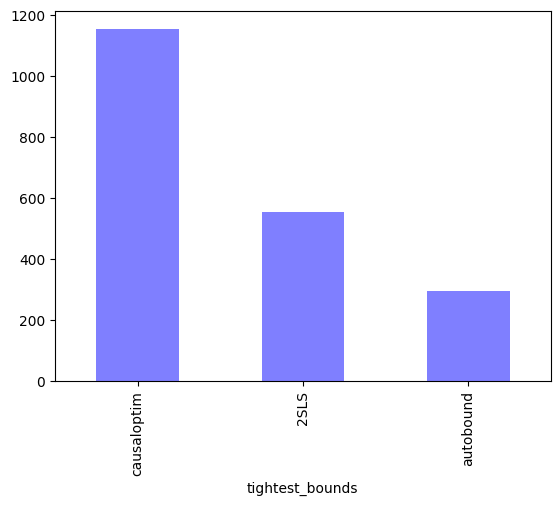

In [43]:
data['tightest_bounds'].value_counts().plot(kind='bar', alpha=0.5, color='blue')


In [5]:
# Define features and target
features = ['entropy_Y', 'entropy_X', 'entropy_Z', 'corr_X_Y', 'corr_X_Z', 'corr_Y_Z']
X = data[features]
y = data['tightest_bounds']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:

# Train the decision tree classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Evaluate the classifier
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        2SLS       0.74      0.80      0.77       108
   autobound       0.32      0.37      0.34        57
 causaloptim       0.74      0.69      0.71       235

    accuracy                           0.67       400
   macro avg       0.60      0.62      0.61       400
weighted avg       0.68      0.67      0.68       400



In [27]:
# Train a random forest classifier to predict 'tightest_bounds'
from sklearn.ensemble import RandomForestClassifier

# Train the random forest classifier
rf_clf = RandomForestClassifier(random_state=42, n_estimators=100)
rf_clf.fit(X_train, y_train)

# Evaluate the random forest classifier
rf_y_pred = rf_clf.predict(X_test)
print(classification_report(y_test, rf_y_pred))

              precision    recall  f1-score   support

        2SLS       0.80      0.83      0.81       108
   autobound       0.36      0.16      0.22        57
 causaloptim       0.76      0.84      0.80       235

    accuracy                           0.74       400
   macro avg       0.64      0.61      0.61       400
weighted avg       0.71      0.74      0.72       400



In [ ]:
# Hyperparameter tuning for the neural network using GridSearchCV
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50), (150, 100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'learning_rate': ['constant', 'adaptive']
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(
    estimator=MLPClassifier(random_state=42, max_iter=500),
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=3,
    verbose=2
)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Print the best parameters and F1 score
print('Best Parameters:', grid_search.best_params_)
print('Best F1 Score:', grid_search.best_score_)

# Evaluate the best model on the test set
best_nn_clf = grid_search.best_estimator_
nn_y_pred = best_nn_clf.predict(X_test)
print(classification_report(y_test, nn_y_pred))

In [10]:
# Run the neural network with the best parameters
best_nn_clf = MLPClassifier(
    random_state=42,
    max_iter=500,
    hidden_layer_sizes=(150, 100, 50),
    activation='relu',
    solver='adam',
    learning_rate='constant'
)

# Train the model
best_nn_clf.fit(X_train, y_train)

# Evaluate the model
nn_y_pred = best_nn_clf.predict(X_test)
print(classification_report(y_test, nn_y_pred))

              precision    recall  f1-score   support

        2SLS       0.89      0.70      0.79       108
   autobound       0.50      0.21      0.30        57
 causaloptim       0.74      0.91      0.81       235

    accuracy                           0.76       400
   macro avg       0.71      0.61      0.63       400
weighted avg       0.74      0.76      0.73       400



Idea:
* New dataset runs through the classifier
* the bounds of the algorithm which the classifier identified as best is automatically returned

In [29]:
# Run each datapoint through best_nn_clf and save the result in a new column
data['metalearner_tightest'] = best_nn_clf.predict(data[features])

# Add a column 'metalearner_bound_width' based on 'metalearner_tightest'
data['metalearner_bound_width'] = data.apply(
    lambda row: row[bound_columns[row['metalearner_tightest']]], axis=1
)

# Add a column 'metalearner_bounds_valid' based on 'metalearner_tightest'
valid_columns = {
    'causaloptim': 'causaloptim_bounds_valid',
    '2SLS': '2SLS_CI_valid',
    'entropyBounds': 'entropyBounds_bounds_valid',
    'autobound': 'autobound_bounds_valid'
}
data['metalearner_bounds_valid'] = data.apply(
    lambda row: row[valid_columns[row['metalearner_tightest']]], axis=1
)

# Display the first few rows to verify
data[['metalearner_tightest', 'metalearner_bound_width', 'metalearner_bounds_valid']].head()

### Display mean bound widths and percentage of invalid bounds
mean_bounds = data[
    ['causaloptim_bound_width', '2SLS_CI_width', 'entropyBounds_bound_width', 'autobound_bound_width', 'metalearner_bound_width']
].mean().to_frame(name='Mean Bound Width').T

invalid_rates = data[
    ['causaloptim_bounds_valid', '2SLS_CI_valid', 'entropyBounds_bounds_valid', 'autobound_bounds_valid', 'metalearner_bounds_valid']
].mean().to_frame(name='Invalid Rate').T


data

,seed,intercept_X,intercept_Y,b_X_Y,b_Z,b_U_X,b_U_Y,ATE_true,p_Y1,p_Y0,Z,U,X,Y,entropy_Y,entropy_X,entropy_Z,entropy_U,corr_X_Y,corr_X_Z,corr_Y_Z,causaloptim_bound_lower,causaloptim_bound_upper,causaloptim_bound_width,causaloptim_bounds_valid,2SLS_CI_level_percent,2SLS_estimation,2SLS_CI_lower,2SLS_CI_upper,2SLS_CI_width,2SLS_CI_valid,entropyBounds_H(conf)_UB,entropyBounds_bound_lower,entropyBounds_bound_upper,entropyBounds_bound_width,entropyBounds_bounds_valid,autobound_bound_lower,autobound_bound_upper,autobound_bound_width,autobound_bounds_valid,ATE_true_smooth,autobound_bound_lower_smooth,autobound_bound_upper_smooth,tightest_bounds,metalearner_tightest,metalearner_bound_width,metalearner_bounds_valid
0,226265,0,0,-5.000,-0.048032,0.773760,1.621096,-0.649498,"[0.032961324273622784, 0.032961324273622784, 0...","[0.8349462801960579, 0.8349462801960579, 0.834...","[0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, ...","[1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, ...","[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, ...",0.610864,0.688909,0.693115,0.693075,-0.656565,0.019347,-0.031424,-0.809524,0.157898,0.967422,True,98.0,-1.495017,-1.000000,1.000000,2.000000,True,1.0,-0.758991,0.240991,0.999983,True,-0.809524,0.156682,0.966206,True,NaN,NaN,NaN,autobound,causaloptim,0.967422,True
1,749299,0,0,-4.995,-0.933267,-0.364429,0.682056,-0.569919,"[0.0067261733291198045, 0.013217026448330598, ...","[0.5, 0.6641973650768443, 0.6641973650768443, ...","[1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, ...","[0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, ...","[0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, ...","[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, ...",0.657883,0.669634,0.693019,0.692755,-0.570238,-0.232985,0.078573,-0.663114,-0.014916,0.648198,True,98.0,-0.333146,-0.710562,0.044271,0.754833,True,1.0,-0.685998,0.313998,0.999996,True,-0.663114,0.109372,0.772486,True,NaN,NaN,NaN,causaloptim,causaloptim,0.648198,True
2,13137,0,0,-4.990,1.689792,0.181567,-0.249923,-0.463390,"[0.00675966051071325, 0.00675966051071325, 0.0...","[0.5, 0.5, 0.5, 0.5, 0.43784247774382445, 0.5,...","[0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, ...","[0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, ...","[0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, ...","[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",0.408578,0.635586,0.693019,0.693019,-0.564891,0.419036,-0.207080,-0.503649,-0.315985,0.187664,True,98.0,-0.366283,-0.519977,-0.212589,0.307388,True,1.0,-0.832000,0.168000,1.000000,True,-0.678990,-0.073715,0.605275,True,NaN,NaN,NaN,causaloptim,causaloptim,0.187664,True
3,94295,0,0,-4.985,-0.324761,0.327115,-2.582697,-0.279781,"[0.0005166144201893448, 0.006793313272604322, ...","[0.07026034714279104, 0.5, 0.5, 0.5, 0.0702603...","[1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, ...","[1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, ...","[0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.442972,0.692859,0.690833,0.693115,-0.418391,-0.034458,-0.002764,-0.625468,0.295944,0.921413,True,98.0,0.059125,-1.000000,1.000000,2.000000,True,1.0,-0.741989,0.257993,0.999982,True,-0.625468,0.328431,0.953899,True,NaN,NaN,NaN,causaloptim,causaloptim,0.921413,True
4,736973,0,0,-4.980,1.285158,0.598297,1.212007,-0.621645,"[0.00682713242213816, 0.00682713242213816, 0.0...","[0.5, 0.5, 0.7706538376815859, 0.7706538376815...","[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, ...","[0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, ...","[1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",0.465274,0.583259,0.690553,0.693115,-0.677121,0.265217,-0.191327,-0.823276,-0.150283,0.672993,True,98.0,-0.618801,-0.873916,-0.363686,0.510230,True,1.0,-0.851002,0.149001,1.000002,True,-0.823276,-0.065427,0.757849,True,NaN,NaN,NaN,2SLS,2SLS,0.510230,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..